In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load Cleaned AREDS DB file

In [2]:
pool = pd.read_csv('20170830_AREDS_DB.csv', index_col=0)

In [3]:
len(pool)

132617

In [4]:
len(pool.Patid.unique())

4540

In [5]:
pool = pool.loc[ pool.SideLR == 'LS']

In [6]:
pool.drop( 'SideLR', axis=1, inplace=True)

In [7]:
len(pool)

66308

### New experiment only deals with Baseline AMD Category 1

In [8]:
pool = pool.loc[ pool.Baseline_AMD_Category == '1']

In [9]:
len( pool)

15837

In [10]:
pool.drop( 'Baseline_AMD_Category', axis=1, inplace=True)

In [11]:
pool.head()

,Patid,Areds_subject_id,converted_file_name,Final_AMD_Phenotype_Group,Final_AMD_Phenotype,Final_Cataract_Phenotype,Study_Visit_Year,Treatment,age_baseline,male,white,Visit,EyeLR,SevScore,SimpleSev,age
56,51011,3587,51011-QUA-F2-LE-LS.tiff,Control,Control,Absent,0.0,Antiox,75.690411,0,1,0,LE,1.0,0.0,75.690411
58,51011,3587,51011-QUA-F2-RE-LS.tiff,Control,Control,Absent,0.0,Antiox,75.690411,0,1,0,RE,1.0,0.0,75.690411
98,51019,G022,51019-04-F2-LE-LS.tiff,Other,Large Drusen Questionable 3,Absent,2.0,Placebo,63.630137,1,1,4,LE,1.0,0.0,65.630137
100,51019,G022,51019-04-F2-RE-LS.tiff,Other,Large Drusen Questionable 3,Absent,2.0,Placebo,63.630137,1,1,4,RE,1.0,0.0,65.630137
102,51019,G022,51019-06-F2-LE-LS.tiff,Other,Large Drusen Questionable 3,Absent,3.0,Placebo,63.630137,1,1,6,LE,1.0,0.0,66.630137


### Create join key

Need a way to join Freekje's AREDS database with the WND-CHARM features dataset coming in.

In [12]:
pool['join_key'] = [ '-'.join( _.split('-')[:4] ) for _ in list(pool.converted_file_name) ]

In [13]:
pool.head()

,Patid,Areds_subject_id,converted_file_name,Final_AMD_Phenotype_Group,Final_AMD_Phenotype,Final_Cataract_Phenotype,Study_Visit_Year,Treatment,age_baseline,male,white,Visit,EyeLR,SevScore,SimpleSev,age,join_key
56,51011,3587,51011-QUA-F2-LE-LS.tiff,Control,Control,Absent,0.0,Antiox,75.690411,0,1,0,LE,1.0,0.0,75.690411,51011-QUA-F2-LE
58,51011,3587,51011-QUA-F2-RE-LS.tiff,Control,Control,Absent,0.0,Antiox,75.690411,0,1,0,RE,1.0,0.0,75.690411,51011-QUA-F2-RE
98,51019,G022,51019-04-F2-LE-LS.tiff,Other,Large Drusen Questionable 3,Absent,2.0,Placebo,63.630137,1,1,4,LE,1.0,0.0,65.630137,51019-04-F2-LE
100,51019,G022,51019-04-F2-RE-LS.tiff,Other,Large Drusen Questionable 3,Absent,2.0,Placebo,63.630137,1,1,4,RE,1.0,0.0,65.630137,51019-04-F2-RE
102,51019,G022,51019-06-F2-LE-LS.tiff,Other,Large Drusen Questionable 3,Absent,3.0,Placebo,63.630137,1,1,6,LE,1.0,0.0,66.630137,51019-06-F2-LE


# Load features

In [14]:
pre = "sept_progression"
feat_file = pre + '_data.npy'
feat_names_file = pre + '_feature_names.txt'
samp_names_file = pre + '_sample_names.txt'
labels_file = pre + '_values.txt'

In [15]:
with open( feat_names_file ) as f:
    feature_names = [ line.rstrip('\n') for line in f ]

In [16]:
with open( samp_names_file ) as f:
    sample_names = [ line.rstrip('\n') for line in f ]

In [17]:
with open( labels_file ) as f:
    labels = [ line.rstrip('\n') for line in f ]

In [18]:
len(labels)/8

1617.0

In [19]:
from collections import Counter

In [20]:
Counter( labels[::8] )

Counter({'case_p_l': 231,
         'case_p_r': 149,
         'case_t_l': 14,
         'case_t_r': 49,
         'control_p_l': 246,
         'control_p_r': 246,
         'control_t_l': 341,
         'control_t_r': 341})

In [21]:
raw = pd.DataFrame( columns=feature_names, data=np.load( feat_file ) )

In [22]:
raw.shape

(12936, 4059)

In [23]:
len(raw)/8

1617.0

In [24]:
sample_groups = [ '-'.join( _.split('/')[2].split('-')[:4] ) 
                          for _ in sample_names ]

In [25]:
raw[ 'groups' ] = sample_groups

### Warning: taking mean does not preserve order of samples

The group string becomes the new index, and things get sorted on that index, so need a way to preserve class composition.

In [26]:
class_dict = dict( set( zip( sample_groups, labels)))

In [27]:
len(class_dict)

1617

## Average over all samples

In [28]:
averaged = raw.groupby('groups').mean()

In [29]:
averaged.shape

(1617, 4059)

### Add the class identity back in

In [30]:
averaged['progressor_class'] = [ class_dict[_] for _ in list( averaged.index ) ]

In [31]:
averaged['progressor_group'] = [ _.split('_')[0] for _ in list(averaged['progressor_class'])]

### Merge with Freekje data

In [32]:
merged = averaged.merge( pool, how='inner', left_index=True, right_on='join_key')

In [33]:
merged.iloc[ :, 4059:]

,progressor_class,progressor_group,Patid,Areds_subject_id,converted_file_name,Final_AMD_Phenotype_Group,Final_AMD_Phenotype,Final_Cataract_Phenotype,Study_Visit_Year,Treatment,age_baseline,male,white,Visit,EyeLR,SevScore,SimpleSev,age,join_key
176,control_p_l,control,51026,2147,51026-04-F2-LE-LS.tiff,Control,Control,Absent,2.0,Placebo,64.117808,0,1,4,LE,1.0,0.0,66.117808,51026-04-F2-LE
178,control_p_r,control,51026,2147,51026-04-F2-RE-LS.tiff,Control,Control,Absent,2.0,Placebo,64.117808,0,1,4,RE,1.0,0.0,66.117808,51026-04-F2-RE
180,control_p_l,control,51026,2147,51026-06-F2-LE-LS.tiff,Control,Control,Absent,3.0,Placebo,64.117808,0,1,6,LE,1.0,0.0,67.117808,51026-06-F2-LE
182,control_p_r,control,51026,2147,51026-06-F2-RE-LS.tiff,Control,Control,Absent,3.0,Placebo,64.117808,0,1,6,RE,1.0,0.0,67.117808,51026-06-F2-RE
184,control_p_l,control,51026,2147,51026-08-F2-LE-LS.tiff,Control,Control,Absent,4.0,Placebo,64.117808,0,1,8,LE,1.0,0.0,68.117808,51026-08-F2-LE
186,control_p_r,control,51026,2147,51026-08-F2-RE-LS.tiff,Control,Control,Absent,4.0,Placebo,64.117808,0,1,8,RE,1.0,0.0,68.117808,51026-08-F2-RE
188,control_p_l,control,51026,2147,51026-10-F2-LE-LS.tiff,Control,Control,Absent,5.0,Placebo,64.117808,0,1,10,LE,1.0,0.0,69.117808,51026-10-F2-LE
190,control_p_r,control,51026,2147,51026-10-F2-RE-LS.tiff,Control,Control,Absent,5.0,Placebo,64.117808,0,1,10,RE,1.0,0.0,69.117808,51026-10-F2-RE
192,control_p_l,control,51026,2147,51026-12-F2-LE-LS.tiff,Control,Control,Absent,6.0,Placebo,64.117808,0,1,12,LE,1.0,0.0,70.117808,51026-12-F2-LE
194,control_p_r,control,51026,2147,51026-12-F2-RE-LS.tiff,Control,Control,Absent,6.0,Placebo,64.117808,0,1,12,RE,1.0,0.0,70.117808,51026-12-F2-RE


In [34]:
merged['progressor_group'].value_counts()

control    1174
case        443
Name: progressor_group, dtype: int64

## Sanity check: Progressor groups should not share participants

Should be no overlap.

In [35]:
len( set( list( merged['Patid'][ merged['progressor_group'] == 'control' ] )) & 
    set( list( merged['Patid'][ merged['progressor_group'] == 'case' ] )) )

0

Good!

# Select single images per participant

Get the percentile boundaries for the age data for each cohort. Need to make sure that younger cases and older controls are represented.

### Criteria for selecting images for age regression problem
1. Evenly sample from age range
2. One image per participant only

### Criteria for selecting images for progressor classification problem
1. Case group: Take the most-recent image that was graded 1 (plus other caviats)
2. Control group: Take images such that the distribution of ages is the same as the case group (matched ages?)

In [36]:
merged['age'].describe()

count    1617.000000
mean       71.618588
std         4.819175
min        60.654795
25%        68.087671
50%        71.265753
75%        74.832877
max        87.912329
Name: age, dtype: float64

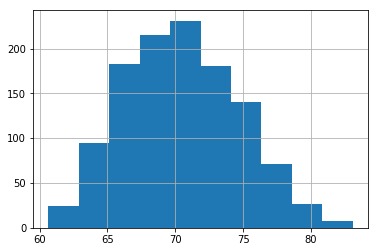

In [37]:
merged['age'][ merged['progressor_group'] == 'control' ].hist()

In [38]:
merged['age'][ merged['progressor_group'] == 'control' ].describe()

count    1174.000000
mean       70.503475
std         4.191305
min        60.654795
25%        67.332877
50%        70.309589
75%        73.441096
max        83.073973
Name: age, dtype: float64

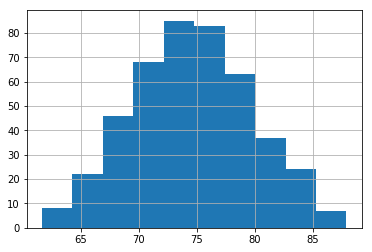

In [39]:
merged['age'][ merged['progressor_group'] == 'case' ].hist()

In [40]:
merged['age'][ merged['progressor_group'] == 'case' ].describe()

count    443.000000
mean      74.573762
std        5.122038
min       61.649315
25%       70.994521
50%       74.512329
75%       78.101370
max       87.912329
Name: age, dtype: float64

### Young cases

In [41]:
len( merged[ (merged['progressor_group'] == 'case') & (merged['age'] < 67.5 ) ] )

41

In [42]:
len(merged.loc[ (merged['progressor_group'] == 'case') & (merged['age'] < 67.5 ), 'Patid' ].unique())

16

### Older controls

In [43]:
len( merged[ (merged['progressor_group'] == 'control') & (merged['age'] > 78 ) ] )

48

In [44]:
len(merged.loc[ (merged['progressor_group'] == 'control') & (merged['age'] > 78 ), 'Patid' ].unique())

11

# Control Regressor

In [45]:
from scipy.stats import gaussian_kde

In [46]:
kernel = gaussian_kde( list( merged['age']))

In [47]:
import matplotlib.pyplot as plt

In [48]:
case = merged[ merged['progressor_group'] == 'case' ].copy()

In [49]:
control = merged[ merged['progressor_group'] == 'control' ].copy()

In [50]:
case_kdeX = np.mgrid[case.age.min():case.age.max():100j]
control_kdeX = np.mgrid[control.age.min():control.age.max():100j]

In [51]:
case_kernel = gaussian_kde( list(case.age) )
control_kernel = gaussian_kde( list(control.age) )

In [52]:
case_kdeY = case_kernel( case_kdeX )
control_kdeY = control_kernel( control_kdeX )

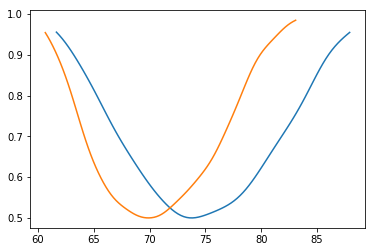

In [53]:
plt.plot( case_kdeX, case_kdeY.max() / (case_kdeY.max() + case_kdeY) )
plt.plot( control_kdeX, control_kdeY.max() / (control_kdeY.max() + control_kdeY) )

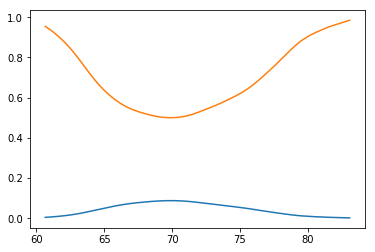

In [54]:
control_X_sorted = sorted( list(control.age) )
control_sorted_pdf = control_kernel( control_X_sorted )
plt.plot( control_X_sorted, control_sorted_pdf )
plt.plot( control_X_sorted, control_sorted_pdf.max() / (control_sorted_pdf.max() + control_sorted_pdf ) )

In [150]:
control_pdf = control_kernel( list(control.age) )
weights = control_pdf.max() / (control_pdf.max() + control_pdf ) 
#control.loc[:, 'weights'] = weights
control.loc[:, 'weights'] = [1]*len( control )

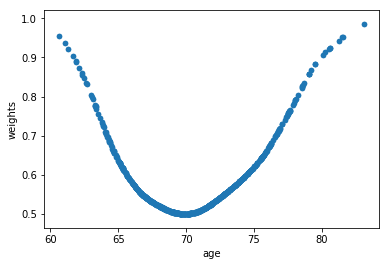

In [147]:
control.plot.scatter( 'age', 'weights')

In [118]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import time

In [153]:
def RegressControls( control, niter=30, seed=42, split_ratio=0.75):
    
    svr_model = Pipeline( [ ('standardize', StandardScaler() ), ('svr', SVR( cache_size=5000) )] )
    # Not having a standard scaler makes bad results worse
    #svr_model = Pipeline( [ ('svr', SVR( cache_size=5000) )] )

    patids = list( control.Patid )
    eyelrs = list( control.EyeLR )
    subset = control[ ['Patid', 'EyeLR', 'weights'] ]
    all_combos = set( zip( patids, eyelrs ) )
    N = len( all_combos )
    rndstate = np.random.RandomState( seed )
    testids = []
    testeyes = []
    testvisits = []
    test_pred = []
    test_actual = []
    #train_stats = []
    #test_stats = []
    for i in range( niter ):
        t1=time.time()
        used = set()
        train_indices = []
        while len( used ) < split_ratio * N:
            row = subset.sample( n=1, weights='weights', random_state=rndstate )
            row_index = int(row.index[0])
            patid, eyelr, w = row.iloc[0].tolist()
            key = ( patid, eyelr ) # Only use a given eye once for training
            if key in used:
                continue
            used.add( key )
            train_indices.append( row_index )
        train_set = control.loc[ train_indices ]
        train_Y = list( train_set.age )
        train_X = train_set.iloc[:, :4059 ].as_matrix()
        test_set = control.loc[ [ c not in used for c in zip( patids, eyelrs ) ] ]
        # Assert no test data in the training set
        assert( len( set( train_indices ) & set( list( test_set.index ) ) ) == 0 )
        #train_stats.extend( list( zip( [i]*len( train_set ), list( train_set.Patid ), 
        #                                 list( train_set.EyeLR ), list( train_set.Visit ),
        #                                 list( train_set.age ) ) ) )
        #test_stats.extend( list( zip( [i]*len( test_set ), list( test_set.Patid ), 
        #                                 list( test_set.EyeLR ), list( test_set.Visit ),
        #                                 list( test_set.age ) ) ) )
        test_Y = list( test_set.age )
        test_X = test_set.iloc[:, :4059 ].as_matrix()
        svr_model.fit( train_X, train_Y )
        train_predY = svr_model.predict( train_X )
        test_predY = svr_model.predict( test_X )
        testids.extend( list( test_set.Patid ) )
        testeyes.extend( list( test_set.EyeLR ) )
        testvisits.extend( list( test_set.Visit ) )
        test_pred.extend( list( test_predY ) )
        test_actual.extend( list( test_set.age ) )

        trainr2 = r2_score( list( train_set.age ), train_predY )        
        testr2 = r2_score( list( test_set.age ), test_predY )
        
        t2=time.time()
        print( "iter{}: tested {}, train R^2={:0.2f}, test R^2={:0.2f}, time={:0.1f}s".format(
            i, len(test_set), trainr2, testr2, t2-t1 ) )

    #return train_stats, test_stats
    return pd.DataFrame.from_dict( {'Patid': testids, 'EyeLR': testeyes, 
                                    'Visit': testvisits, 'Pred': test_pred, 'Act': test_actual} )

In [128]:
control.age.describe()

count    1174.000000
mean       70.503475
std         4.191305
min        60.654795
25%        67.332877
50%        70.309589
75%        73.441096
max        83.073973
Name: age, dtype: float64

# Weights ^ 4

In [142]:
results = RegressControls( control, niter=50, seed=None, split_ratio=0.90 )

iter0: tested 85, train R^2=0.32, test R^2=0.13, time=1.3s
iter1: tested 77, train R^2=0.35, test R^2=-0.03, time=1.6s
iter2: tested 81, train R^2=0.35, test R^2=0.21, time=1.5s
iter3: tested 78, train R^2=0.35, test R^2=0.01, time=1.5s
iter4: tested 77, train R^2=0.33, test R^2=0.08, time=1.4s
iter5: tested 88, train R^2=0.33, test R^2=0.06, time=1.4s
iter6: tested 82, train R^2=0.33, test R^2=0.20, time=1.5s
iter7: tested 78, train R^2=0.33, test R^2=0.03, time=1.5s
iter8: tested 85, train R^2=0.37, test R^2=-0.09, time=1.5s
iter9: tested 82, train R^2=0.36, test R^2=-0.21, time=1.7s
iter10: tested 78, train R^2=0.36, test R^2=0.04, time=1.6s
iter11: tested 78, train R^2=0.33, test R^2=0.10, time=1.7s
iter12: tested 77, train R^2=0.39, test R^2=0.13, time=1.6s
iter13: tested 80, train R^2=0.36, test R^2=-0.19, time=1.5s
iter14: tested 86, train R^2=0.39, test R^2=-0.10, time=1.5s
iter15: tested 88, train R^2=0.38, test R^2=0.01, time=1.6s
iter16: tested 83, train R^2=0.32, test R^2=0

           Act      Pred
Act   1.000000  0.332514
Pred  0.332514  1.000000


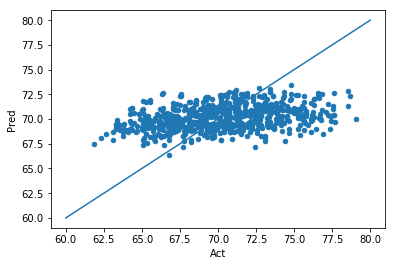

In [143]:
macro_results = results.groupby( ['Patid', 'EyeLR', 'Visit'] ).mean()
print( macro_results.corr() )
macro_results.plot.scatter( 'Act', 'Pred')
plt.plot( (60,80), (60,80))

# weights ^1

In [148]:
results = RegressControls( control, niter=50, seed=None, split_ratio=0.90 )

iter0: tested 93, train R^2=0.34, test R^2=0.07, time=1.2s
iter1: tested 79, train R^2=0.31, test R^2=0.03, time=1.2s
iter2: tested 92, train R^2=0.35, test R^2=0.12, time=1.3s
iter3: tested 81, train R^2=0.30, test R^2=0.02, time=1.2s
iter4: tested 77, train R^2=0.28, test R^2=0.01, time=1.2s
iter5: tested 81, train R^2=0.30, test R^2=0.10, time=1.3s
iter6: tested 95, train R^2=0.31, test R^2=0.00, time=1.3s
iter7: tested 80, train R^2=0.30, test R^2=0.14, time=1.2s
iter8: tested 82, train R^2=0.28, test R^2=-0.75, time=1.2s
iter9: tested 74, train R^2=0.31, test R^2=-0.12, time=1.3s
iter10: tested 74, train R^2=0.31, test R^2=0.10, time=1.1s
iter11: tested 93, train R^2=0.28, test R^2=0.03, time=1.3s
iter12: tested 82, train R^2=0.32, test R^2=0.12, time=1.4s
iter13: tested 83, train R^2=0.29, test R^2=0.12, time=1.3s
iter14: tested 77, train R^2=0.34, test R^2=-0.02, time=1.4s
iter15: tested 72, train R^2=0.38, test R^2=0.03, time=1.3s
iter16: tested 72, train R^2=0.30, test R^2=-0.

           Act      Pred
Act   1.000000  0.343749
Pred  0.343749  1.000000


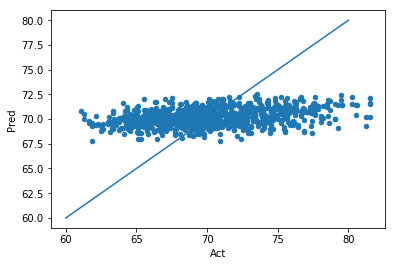

In [149]:
macro_results = results.groupby( ['Patid', 'EyeLR', 'Visit'] ).mean()
print( macro_results.corr() )
macro_results.plot.scatter( 'Act', 'Pred')
plt.plot( (60,80), (60,80))

# No weights, without standard scaling

In [154]:
results = RegressControls( control, niter=50, seed=None, split_ratio=0.90 )

iter0: tested 76, train R^2=0.33, test R^2=-0.17, time=1.2s
iter1: tested 78, train R^2=0.34, test R^2=-0.05, time=1.2s
iter2: tested 66, train R^2=0.31, test R^2=-0.01, time=1.6s
iter3: tested 82, train R^2=0.34, test R^2=-0.00, time=1.3s
iter4: tested 89, train R^2=0.33, test R^2=-0.09, time=1.2s
iter5: tested 80, train R^2=0.33, test R^2=-0.00, time=1.2s
iter6: tested 76, train R^2=0.33, test R^2=-0.21, time=1.4s
iter7: tested 69, train R^2=0.31, test R^2=-0.03, time=1.3s
iter8: tested 71, train R^2=0.35, test R^2=-0.07, time=1.3s
iter9: tested 78, train R^2=0.32, test R^2=-0.05, time=1.1s
iter10: tested 75, train R^2=0.35, test R^2=-0.06, time=1.2s
iter11: tested 75, train R^2=0.35, test R^2=-0.01, time=1.2s
iter12: tested 68, train R^2=0.34, test R^2=-0.27, time=1.2s
iter13: tested 84, train R^2=0.32, test R^2=-0.06, time=1.2s
iter14: tested 73, train R^2=0.35, test R^2=-0.13, time=1.2s
iter15: tested 79, train R^2=0.32, test R^2=-0.10, time=1.2s
iter16: tested 73, train R^2=0.34,

           Act      Pred
Act   1.000000 -0.088566
Pred -0.088566  1.000000


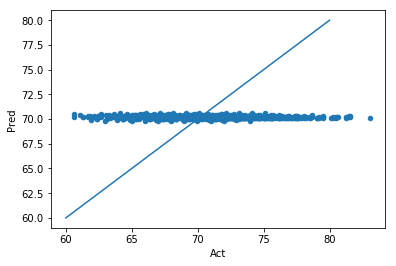

In [155]:
macro_results = results.groupby( ['Patid', 'EyeLR', 'Visit'] ).mean()
print( macro_results.corr() )
macro_results.plot.scatter( 'Act', 'Pred')
plt.plot( (60,80), (60,80))

count    8400.000000
mean       70.542134
std         5.366785
min        60.654795
25%        65.832877
50%        70.375342
75%        75.117808
max        83.073973
dtype: float64
count    8984.000000
mean       69.792071
std         3.205677
min        60.654795
25%        67.364384
50%        69.638356
75%        71.890411
max        79.071233
dtype: float64


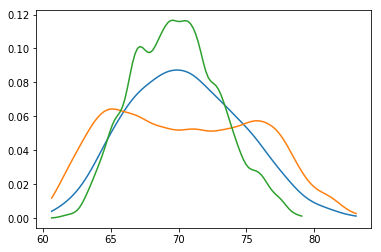

In [116]:
#train_stats, test_stats = RegressControls( control, niter=10, seed=None, split_ratio=0.80 )
#plt.plot( control_kdeX, control_kdeY )

#sampled_train_ages = list( zip(*train_stats))[-1]
#print( pd.Series( sampled_train_ages ).describe() )
#train_sample_kdeX = np.mgrid[ min(sampled_train_ages) : max(sampled_train_ages) : 100j ]
#train_sample_kernel = gaussian_kde( sampled_train_ages )
#train_sample_kdeY = train_sample_kernel( train_sample_kdeX )
#plt.plot( X2, Y2 )
#plt.plot( train_sample_kdeX, train_sample_kdeY  )

#sampled_test_ages = list( zip(*test_stats))[-1]
#print( pd.Series( sampled_test_ages ).describe() )
#test_sample_kdeX = np.mgrid[ min(sampled_test_ages) : max(sampled_test_ages) : 100j ]
#test_sample_kernel = gaussian_kde( sampled_test_ages )
#test_sample_kdeY = test_sample_kernel( test_sample_kdeX )
#plt.plot( X2, Y2 )
#plt.plot( test_sample_kdeX, test_sample_kdeY  )

# Progressor classifier: Define 5 bin boundaries to evenly sample from

60-67.5, 67.5-70.6, 70.6-74.0, 74.0-78.0, 78.0-88

In [ ]:
merged['age'][ merged['progressor_group'] == 'control' ].hist(bins=[60, 67.5, 70.6, 74.0, 78.0, 88], edgecolor='black' )

In [ ]:
merged['age'][ merged['progressor_group'] == 'case' ].hist(bins=[60, 67.5, 70.6, 74.0, 78.0, 88], edgecolor='black' )

# Add bin assignment to spreadsheet

Discretize age data two ways: a crossover bin when comparing cases and controls, as well as a in-group bin based on in-group quartiles.

In [ ]:
merged['crossover_bin'] = pd.cut( merged['age'], bins=[60, 67.5, 70.6, 74.0, 78.0, 88], labels=['A', 'B', 'C', 'D', 'E'] )

In [ ]:
merged['crossover_bin'][ merged['progressor_group'] == 'case' ].value_counts()

In [ ]:
merged['crossover_bin'][ merged['progressor_group'] == 'control' ].value_counts()

# Pivot all observations for a given participant onto a single row

In [ ]:
longitudinal = right_eye.pivot( index='DB_ID', columns='Visit', values='SevScore')

In [ ]:
len(longitudinal)

In [ ]:
longitudinal.sort_index(inplace=True)

# Identify progressors last 1grade before taking off

In [ ]:
longitudinal['Last1BeforeChange'] = [np.nan]*len(longitudinal)

In [ ]:
def shiftleft( row ):
    wanted_indices = list(row.index)[:-1]
    #print zip(wanted_indices, row.index)
    sub = row.loc[ wanted_indices ]
    n_unique_vals = len( set( list( sub.dropna() ) ) )
    assert( n_unique_vals ) # are there actually graded images in this row?
    if n_unique_vals == 1:
        # Grade stays constant throughout, do a simple shift
        # This will also catch the case if there's only one graded image
        for i, val in sub.iteritems():
            if not np.isnan(val):
                break
        shifted = sub[i:]
        shifted.index = range(len(shifted))
        return shifted.reindex(row.index, fill_value=np.nan)
    else:
        # figure out the column that has the last grade of "1" before changing to something else
        crop_index = 0
        last_grade = None
        # iterate over all entries in the row
        for i, curr_grade in sub.iteritems():
            if not np.isnan( curr_grade ):
                if( last_grade == None ) or ( last_grade == curr_grade ):
                    # The first time we see a grade, or the grade we see is the same as the last
                    crop_index = i
                    last_grade = curr_grade
                else:
                    # Break out now, the grade we see is different than the last one we saw
                    break

        shifted = sub[ crop_index:]
        shifted.index = range(len(shifted))
        retval = shifted.reindex(row.index, fill_value=np.nan)
        retval['Last1BeforeChange'] = crop_index
        return retval

In [ ]:
shifted_longitudinal = longitudinal.apply( func=shiftleft, axis=1 )
shifted_longitudinal.sort_index(inplace=True)

# Filter out rows that don't start on the low end

In [ ]:
shifted_longitudinal = shifted_longitudinal[ shifted_longitudinal[0] == 1]

In [ ]:
len(shifted_longitudinal)

# Control: rows that don't change 

Will have value nan for cell Last1BeforeChange

In [ ]:
control = shifted_longitudinal[shifted_longitudinal['Last1BeforeChange'].isnull()]

In [ ]:
len(control)

In [ ]:
control = control[ control[22] == 1 ]

In [ ]:
len(control)

# Case

Now: if you started off as a 1 but you had a score of 5 or higher at any point subsequently
Future: Use image that was your last grade 1 before you increased

In [ ]:
last_visit_before_change = shifted_longitudinal['Last1BeforeChange']

In [ ]:
shifted_longitudinal.drop('Last1BeforeChange', axis=1, inplace=True)

In [ ]:
cases = shifted_longitudinal[ shifted_longitudinal.max(axis=1) >= 5 ]

In [ ]:
len(cases)